In [1]:
import jax
import jax.numpy as np
import jraph
import flax.linen as nn
import numpy as onp
import matplotlib.pyplot as plt

from functools import partial

from jax.config import config
config.update("jax_debug_nans", True)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../")

from models.gnn import GraphConvNet
from models.graph_utils import nearest_neighbors
from models.graph_utils import add_graphs_tuples
from models.train_utils import create_input_iter
from models.egnn_jax import EGNN
from models.graph_utils import rotate_representation

In [4]:
from datasets import load_data

In [5]:
n_nodes = 300
n_batch = 4
n_samples = 4

In [6]:
train_ds, norm_dict = load_data("nbody", 3, n_nodes, n_batch, 234, small=True, n_samples=n_samples)

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [7]:
tuple(map(float, norm_dict['mean']))

(497.149658203125, 499.62109375, 498.3173522949219)

In [8]:
batches = create_input_iter(train_ds)
x_data = next(batches)
x = x_data[0][0]
cond = x_data[1][0]

In [9]:
k = 20

In [10]:
sources, targets = jax.vmap(nearest_neighbors, in_axes=(0, None))(x, k)

In [11]:
def translate_pbc(coordinates, translation_vector, box_size):
    """
    Translate a batch of coordinates and apply periodic boundary conditions.

    :param coordinates: np.array of shape (batch, points, 3) containing the coordinates
    :param translation_vector: np.array of shape (3,) containing the translation vector
    :param box_size: float representing the box size
    :return: np.array of shape (batch, points, 3) containing the translated coordinates
    """

    # Translate the coordinates
    translated_coordinates = coordinates + translation_vector

    # Apply periodic boundary conditions
    translated_coordinates = np.mod(translated_coordinates, box_size)

    return translated_coordinates

## EGNN; equivariance test

Just the base GNN. Rotate the box and check if the output is equivariant.

In [12]:
coord_mean, coord_std, box_size = norm_dict['mean'], norm_dict['std'], 1000.
unit_cell = np.array([[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]])

In [13]:
class GraphWrapper(nn.Module):
    @nn.compact
    def __call__(self, graph, pos):
        return jax.vmap(EGNN(k=k), in_axes=(0, 0, 0, 0, None, None, None, None))(graph, pos, None, None, coord_mean, coord_std, box_size, unit_cell)
    
model = GraphWrapper()
rng = jax.random.PRNGKey(42)

In [14]:
d2 = np.sum(x ** 2, axis=-1, keepdims=True)

### Rotation equivariance

In [15]:
pos = x
pos_rot = jax.vmap(rotate_representation, in_axes=(0,None,None))(x, 45, np.array([0., 0., 1.]))

In [16]:
graph = jraph.GraphsTuple(
          n_node=np.array(n_batch * [[n_nodes]]), 
          n_edge=np.array(n_batch * [[k]]),
          nodes=d2, 
          edges=None,
          globals=cond,
          senders=sources,
          receivers=targets)

pos_out, _ = model.init_with_output(rng, graph, pos)

In [17]:
graph = jraph.GraphsTuple(
          n_node=np.array(n_batch * [[n_nodes]]), 
          n_edge=np.array(n_batch * [[k]]),
          nodes=d2, 
          edges=None,
          globals=cond,
          senders=sources,
          receivers=targets)

pos_rot_out, _ = model.init_with_output(rng, graph, pos_rot)

In [18]:
pos_out_rot = jax.vmap(rotate_representation, in_axes=(0,None,None))(pos_out, 45, np.array([0., 0., 1.]))

In [19]:
pos_rot_out / pos_out_rot

Array([[[0.999997  , 0.99999976, 0.99999887],
        [1.0000006 , 0.9999979 , 1.        ],
        [1.0000052 , 1.0000004 , 1.0000006 ],
        ...,
        [1.0000014 , 0.99999946, 1.0000012 ],
        [0.99999857, 0.9999976 , 0.99999905],
        [1.0000075 , 1.000009  , 1.0000062 ]],

       [[0.9999999 , 1.0000001 , 0.9999981 ],
        [1.0027623 , 1.0294071 , 1.0007257 ],
        [1.0000021 , 0.99997884, 0.99999744],
        ...,
        [0.9998186 , 1.0000073 , 1.0000567 ],
        [1.0000023 , 0.9999997 , 0.999999  ],
        [1.000004  , 1.0000169 , 0.99999803]],

       [[0.99998623, 0.9999334 , 0.9999065 ],
        [0.99988806, 0.9998452 , 1.0002387 ],
        [0.9689842 , 1.0332767 , 1.003476  ],
        ...,
        [0.9343062 , 0.99948573, 0.99909335],
        [0.99984014, 1.0000125 , 1.000338  ],
        [1.1363615 , 1.0001159 , 1.0006788 ]],

       [[0.9987553 , 0.99891716, 1.0044956 ],
        [1.0000407 , 0.99985135, 0.99952686],
        [0.9985229 , 0.9959252 , 0.

### Translation equivariance

In [20]:
tran = np.array([-0.45, 0.9, -1.2])[None, None, :]
pos_tran = pos + tran
pos_out_tran = pos_out + tran

In [21]:
graph = jraph.GraphsTuple(
          n_node=np.array(n_batch * [[n_nodes]]), 
          n_edge=np.array(n_batch * [[k]]),
          nodes=d2, 
          edges=None,
          globals=cond,
          senders=sources,
          receivers=targets)

pos_tran_out, _ = model.init_with_output(rng, graph, pos_tran)

In [22]:
pos_tran_out / pos_out_tran

Array([[[ 1.1976627e-01,  8.0889188e-02, -6.9857992e-02],
        [ 7.3073722e-02, -1.0363261e-02, -1.4617759e-02],
        [-2.3938985e-01, -7.5541645e-02,  7.4414194e-02],
        ...,
        [-5.6628186e-01,  2.5665242e-02,  1.6626061e-01],
        [-2.8057891e-01,  7.9674259e-02, -6.9290578e-02],
        [ 5.3373024e-02, -7.8272270e-03,  1.2681507e-02]],

       [[ 2.5653741e-01, -8.3892286e-02,  8.3418734e-02],
        [ 5.8481865e-02, -3.5797618e-02,  2.3776965e-02],
        [-5.6316610e-02,  1.8669665e-02, -4.5809042e-02],
        ...,
        [ 2.4829493e-01,  1.0061856e-01,  3.9710082e-02],
        [ 1.4790554e-01,  5.3158436e-02,  7.7980622e-03],
        [ 8.8622170e-03, -2.2965036e-03,  1.0770296e-02]],

       [[-2.6570410e-01,  2.0473979e-01,  7.7884682e-02],
        [ 3.0200401e-02,  1.1512348e-01,  1.5344918e-01],
        [-5.3831168e-02, -2.7647036e-01, -7.0102550e-02],
        ...,
        [ 1.7516038e-01, -4.9181405e-02, -5.4271363e-02],
        [-1.5988071e-03, -1.0

In [23]:
tran = np.array([700., 100., 800.])
pos_tran = (translate_pbc(pos * coord_std + coord_mean, tran, 1000.) - coord_mean) / coord_std
pos_out_tran = (translate_pbc(pos_out * coord_std + coord_mean, tran, 1000.) - coord_mean) / coord_std

In [24]:
graph = jraph.GraphsTuple(
          n_node=np.array(n_batch * [[n_nodes]]), 
          n_edge=np.array(n_batch * [[k]]),
          nodes=d2, 
          edges=None,
          globals=cond,
          senders=sources,
          receivers=targets)

pos_tran_out, _ = model.init_with_output(rng, graph, pos_tran)

In [25]:
pos_tran_out / pos_out_tran

Array([[[ 5.60404249e-02,  1.84747890e-01, -1.26133814e-01],
        [ 3.32537107e-02, -2.71271970e-02, -2.53394991e-02],
        [-9.20334309e-02, -2.20781133e-01,  1.21194646e-01],
        ...,
        [-1.87298313e-01,  6.35184720e-02,  2.54879981e-01],
        [-1.05706178e-01,  1.82282239e-01, -1.25055924e-01],
        [ 2.40101349e-02, -2.04058066e-02,  2.15574671e-02]],

       [[ 1.30856499e-01, -2.48902351e-01,  1.35033727e-01],
        [ 2.63870656e-02, -9.76835415e-02,  4.01035845e-02],
        [-2.38164738e-02,  4.67001274e-02, -8.12408403e-02],
        ...,
        [ 1.25967920e-01,  2.23644570e-01,  6.62346557e-02],
        [ 7.04047754e-02,  1.26304641e-01,  1.33021092e-02],
        [ 3.88622284e-03, -5.93482982e-03,  1.83335748e-02]],

       [[-1.00831650e-01,  3.98646146e-01,  1.26548693e-01],
        [ 1.34055922e-02,  2.50936955e-01,  2.37182766e-01],
        [-2.27962751e-02, -1.26092172e+00, -1.26598552e-01],
        ...,
        [ 8.47995654e-02, -1.37271017e-01,

## Look at VLB loss

In [26]:
from models.diffusion import VariationalDiffusionModel
from flax.core import FrozenDict
from models.diffusion_utils import loss_vdm
from models.train_utils import create_input_iter, param_count, train_step

In [27]:
train_ds, norm_dict_tmp = load_data("nbody", 3, n_nodes, n_batch, 23, small=True)

In [28]:
batches = create_input_iter(train_ds)

In [29]:
x, conditioning, mask = next(batches)
x, conditioning, mask = x[0], conditioning[0], mask[0]

In [30]:
score_dict = FrozenDict({"k":20, "n_pos_features":3})  # GNN args
# score_dict = FrozenDict({"k":20, "n_pos_features":3, "latent_size":53, "num_mlp_layers":2, "message_passing_steps":4})  # GNN args
score = "egnn"

encoder_dict = decoder_dict = FrozenDict({})
norm_dict = FrozenDict({"x_mean":tuple(map(float, norm_dict_tmp['mean'])), "x_std":tuple(map(float, norm_dict_tmp['std'])), "box_size":1000.})  # GNN args

vdm = VariationalDiffusionModel(
          timesteps=0, 
          d_t_embedding=16,
          d_feature=3,
          score=score,
          score_dict=score_dict,
          n_classes=0,
          embed_context=True,
          d_context_embedding=16,
          noise_schedule="learned_linear",
          gamma_min=-8.,
          gamma_max=14.,
          use_encdec=False,
          encoder_dict=encoder_dict,
          decoder_dict=decoder_dict,
          norm_dict=norm_dict)

In [31]:
x.shape, conditioning.shape, mask.shape

((4, 300, 3), (4, 2), (4, 300))

In [32]:
rng = jax.random.PRNGKey(42)
out, params = vdm.init_with_output({"sample": rng, "params": rng}, x, conditioning, mask);

### Check rotational invariance of loss

In [33]:
loss_diff, loss_klz, loss_recon = vdm.apply(params, x, conditioning, mask, rngs={"sample": rng})
loss_batch = (((loss_diff + loss_klz) * mask[:, :, None]).sum((-1, -2)) + (loss_recon * mask[:, :, None]).sum((-1, -2))) / mask.sum(-1)
loss_batch

Array([ 7.430238 ,  7.4530516, 11.021237 ,  9.010887 ], dtype=float32)

In [34]:
x_rot = jax.vmap(rotate_representation, in_axes=(0,None,None))(x, 45., np.array([0., 0., 1.]))
loss_diff, loss_klz, loss_recon = vdm.apply(params, x_rot, conditioning, mask, rngs={"sample": rng})
loss_batch = (((loss_diff + loss_klz) * mask[:, :, None]).sum((-1, -2)) + (loss_recon * mask[:, :, None]).sum((-1, -2))) / mask.sum(-1)
loss_batch

Array([ 7.4292154,  7.476795 , 10.986766 ,  9.122906 ], dtype=float32)

In [35]:
x_rot = jax.vmap(rotate_representation, in_axes=(0,None,None))(x, 11., np.array([0., 1. / np.sqrt(2), 1. / np.sqrt(2)]))
loss_diff, loss_klz, loss_recon = vdm.apply(params, x_rot, conditioning, mask, rngs={"sample": rng})
loss_batch = (((loss_diff + loss_klz) * mask[:, :, None]).sum((-1, -2)) + (loss_recon * mask[:, :, None]).sum((-1, -2))) / mask.sum(-1)
loss_batch

Array([ 7.4445086,  7.460083 , 11.024262 ,  9.02935  ], dtype=float32)

### Check rotational invariance of loss (individual components)

In [36]:
loss_diff, loss_klz, loss_recon = vdm.apply(params, x, conditioning, mask, rngs={"sample": rng})
(loss_diff * mask[:, :, None]).sum((-1, -2)) / mask.sum(-1)

Array([24.193056, 24.192549, 27.676998, 25.627758], dtype=float32)

In [37]:
x_rot = jax.vmap(rotate_representation, in_axes=(0,None,None))(x, 45., np.array([0., 0., 1.]))
loss_diff, loss_klz, loss_recon = vdm.apply(params, x_rot, conditioning, mask, rngs={"sample": rng})
(loss_diff * mask[:, :, None]).sum((-1, -2)) / mask.sum(-1)

Array([24.192032, 24.216293, 27.642527, 25.739788], dtype=float32)

In [38]:
x_rot = jax.vmap(rotate_representation, in_axes=(0,None,None))(x, 93., np.array([0., 1. / np.sqrt(2), 1. / np.sqrt(2)]))
loss_diff, loss_klz, loss_recon = vdm.apply(params, x_rot, conditioning, mask, rngs={"sample": rng})
(loss_diff * mask[:, :, None]).sum((-1, -2)) / mask.sum(-1)

Array([24.195824, 24.201284, 27.641396, 25.688555], dtype=float32)

### Check translational invariance of loss

In [39]:
loss_diff, loss_klz, loss_recon = vdm.apply(params, x, conditioning, mask, rngs={"sample": rng})
loss_batch = (((loss_diff + loss_klz) * mask[:, :, None]).sum((-1, -2)) + (loss_recon * mask[:, :, None]).sum((-1, -2))) / mask.sum(-1)
loss_batch

Array([ 7.430238 ,  7.4530516, 11.021237 ,  9.010887 ], dtype=float32)

In [40]:
# Translate
tran = np.array([112., 12., -100.])
# x_tran = (translate_pbc(x * coord_std + coord_mean, tran, 1000.) - coord_mean) / coord_std
x_tran = (x * coord_std + coord_mean + tran) / coord_std

loss_diff, loss_klz, loss_recon = vdm.apply(params, x_tran, conditioning, mask, rngs={"sample": rng})
loss_batch = (((loss_diff + loss_klz) * mask[:, :, None]).sum((-1, -2)) + (loss_recon * mask[:, :, None]).sum((-1, -2))) / mask.sum(-1)
loss_batch

Array([ 7.431844,  7.45472 , 11.022846,  9.012527], dtype=float32)

## Train

In [41]:
import optax

In [52]:
train_steps = 10000

schedule = optax.warmup_cosine_decay_schedule(init_value=0.0, peak_value=3e-4, warmup_steps=1, decay_steps=train_steps)
opt = optax.adamw(learning_rate=schedule, weight_decay=1e-4)

In [53]:
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4))
def train_step(state, batch, rng, model, loss_fn):
    """Train for a single step."""
    x, conditioning, mask = batch
    loss, grads = jax.value_and_grad(loss_fn)(state.params, model, rng, x, conditioning, mask)
    grads = jax.lax.pmean(grads, "batch")
    new_state = state.apply_gradients(grads=grads)
    metrics = {"loss": jax.lax.pmean(loss, "batch")}
    return new_state, metrics

In [54]:
import flax
from flax.training import train_state
from tqdm import trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate


state = train_state.TrainState.create(apply_fn=vdm.apply, params=params, tx=opt)
pstate = replicate(state)

with trange(train_steps) as steps:
    for step in steps:

        rng, *train_step_rng = jax.random.split(rng, num=jax.local_device_count() + 1)
        train_step_rng = np.asarray(train_step_rng)

        pstate, metrics = train_step(pstate, next(batches), train_step_rng, vdm, loss_vdm)
        steps.set_postfix(val=unreplicate(metrics["loss"]))

100%|██████████| 10000/10000 [36:45<00:00,  4.54it/s, val=3.6782475]  


In [55]:
from models.diffusion_utils import generate

# Sample batch
x, conditioning, mask = next(batches)
x, conditioning, mask = x[0], conditioning[0], mask[0]

# Gen
rng = jax.random.PRNGKey(42)
x_samples = generate(vdm, unreplicate(pstate).params, rng, (n_batch, n_nodes), conditioning, mask=mask, steps=100).mean()


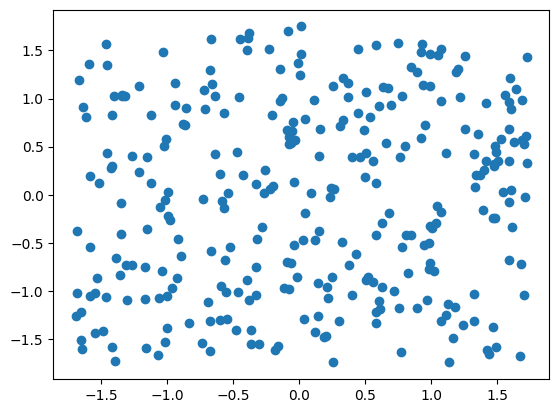

In [56]:
idx = 2

x_samples_unnorm = np.mod(x_samples * coord_std + coord_mean, 1000.)
x_samples_box = (x_samples_unnorm - coord_mean) / coord_std

plt.scatter(x_samples_box[idx, :, 0], x_samples_box[idx, :, 1])

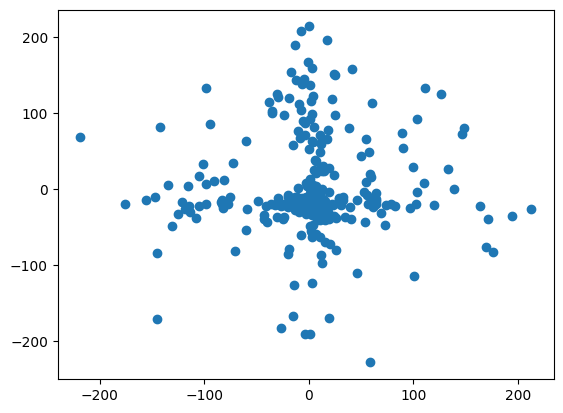

In [57]:
plt.scatter(x_samples[idx, :, 0], x_samples[idx, :, 1])

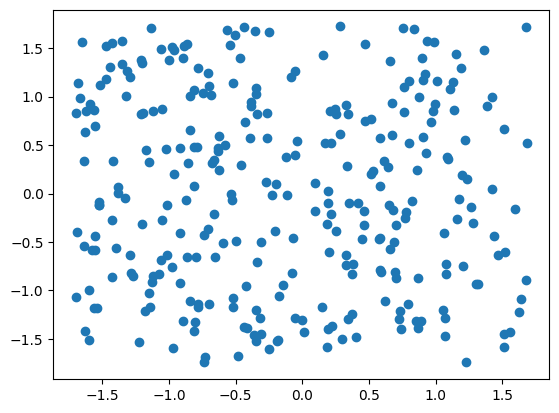

In [58]:
plt.scatter(x[idx, :, 0], x[idx, :, 1])